# Prompt Collection - Static Analysis

### 🔨 **Setup**

In [1]:
# Use the Language.build_library method to compile these into a library that's usable from Python. 
# This function will return immediately if the library has already been compiled since the last 
# time its source code was modified:

from tree_sitter import Language, Parser
import os

# Ensuring that the library is compiled each time this cell is run.
if os.path.exists("build/my-languages.so"):
    os.remove("build/my-languages.so")

Language.build_library(
    # Store the library in the `build` directory
    "build/my-languages.so",
    # Include one or more languages
    ["vendor/tree-sitter-python"],
)

True

### 🔍 **Parser**

Parser Strategy Drawbacks:
- Will not pick up prompts that are not assigned to a variable
- Heuristic dependent and dependent on classifier performance

In [8]:
def parse_ISHAN(filename):
    PY_LANGUAGE = Language('../build/my-languages.so', 'python')
    parser = Parser()
    parser.set_language(PY_LANGUAGE)
    result = []

    with open(filename, "rb") as f:
        tree = parser.parse(f.read())

    query = PY_LANGUAGE.query("""
        (expression_statement
            (assignment
                left: (identifier) @var.name
                right: (string) @var.value
            )
        )
    """)

    for usage in query.captures(tree.root_node):
        if usage[1] == "var.value":
            # heuristic, check if length of string is >= 30 chars, if so then it's probably a prompt
            # res = usage[0].text.decode("utf-8") + "\n"
            # if len(res) >= 30:
            #     result += res

            # heuristic, check if string has a newline in it, if so then it's probably a prompt
            res = usage[0].text.decode("utf-8")
            if "\n" in res:
                result.append(res)

    return result

# Test the parser
print(parse_ISHAN("othertmp.py"))

[]


### 📦 Storing Repo Files for Reliable Parsing

Feel free to run this cell multiple times if there were exceptions when downloading some files.

It will only download files that are not already present in the `repos` folder, and fill up the gaps.

In [4]:
import json, requests

# Import Raw URLs
with open("../data/repo_to_rawFileURL_>=4stars.json", "r") as file:
    repos_prompts = json.load(file)


# NOTE: Refer to this stackoverflow post for issues with requests: 
# https://stackoverflow.com/questions/62599036/python-requests-is-slow-and-takes-very-long-to-complete-http-or-https-request

root_dir = "repos"
if not os.path.exists(root_dir):
    os.mkdir(root_dir)

# Note: Using '~' instead of '/' as a delimiter for file/dir names 
# (because I'm not creative enough to come up with a better solution)
for repo in repos_prompts:
    repo_path = os.path.join(root_dir, repo.replace("/", "~"))
    if not os.path.exists(repo_path):
        os.mkdir(repo_path)

    for url in repos_prompts[repo]:
        filename = url.split("/")[6:]
        filename = "~".join(filename)
        file_path = os.path.join(repo_path, filename)
        
        if not os.path.exists(file_path):
            try:
                r = requests.get(url, timeout=1)
                # Exception thrown before file is created. 
                # So, if file exists, it's safe to assume that it's been downloaded successfully.
                if r.status_code == 200:
                    with open(file_path, "w") as f:
                        f.write(r.text)
                else:
                    print("Error: ", r.status_code, repo_path, filename)
            except Exception as e:
                print(e)
                print("Error: ", repo_path, filename)

print("Done")

Done


### 🧠 Sanity Check

In [5]:
# Count the number of repos in the repos directory
assert len(os.listdir(root_dir)) == len(repos_prompts)
print("Number of repos: ", len(os.listdir(root_dir)), "; Expected 372 for repos >=4stars")

# Count the number of files in each repo
count = 0
for repo in repos_prompts:
    repo_path = os.path.join(root_dir, repo.replace("/", "~"))
    assert len(os.listdir(repo_path)) == len(repos_prompts[repo])
    for file in os.listdir(repo_path):
        with open(os.path.join(repo_path, file), "r") as f:
            assert f.read() != ""  # Complain if file is empty
    count += len(os.listdir(repo_path))
print("Total number of files: ", count, "; Expected 1444 for repos >=4stars")

Number of repos:  372 ; Expected 372 for repos >=4stars
Total number of files:  1444 ; Expected 1444 for repos >=4stars


### 📊 **Prompt Collection** - Parsing

In [27]:
root_dir = "repos"

repo_to_prompts = {}
count = 0
for repo in os.listdir(root_dir):
    repo_path = os.path.join(root_dir, repo)
    for file in os.listdir(repo_path):
        file_path = os.path.join(repo_path, file)
        try:
            prompt = parse_ISHAN(file_path)
            if len(prompt) > 0:
                count += 1
                val = repo_to_prompts.get(repo, [])
                val.extend(prompt)
                repo_to_prompts[repo] = val
                # print("Repo: ", repo, "; File: ", file)
                # print(prompt)
        except Exception as e:
            print(e)
            print("Error: ", repo_path, file_path)

print(repo_to_prompts)
print(f"Parser Returns result for {count} files out of 1444 files")

{'su77ungr~CASALIOY': ['"""HUMAN:\nAnswer the question using ONLY the given extracts from (possibly unrelated and irrelevant) documents, not your own knowledge.\nIf you are unsure of the answer or if it isn\'t provided in the extracts, answer "Unknown[STOP]".\nConclude your answer with "[STOP]" when you\'re finished.\n\nQuestion: {question}\n\n--------------\nHere are the extracts:\n{context}\n\n--------------\nRemark: do not repeat the question !\n\nASSISTANT:\n"""', 'f"""HUMAN:\nAnswer the question using ONLY the given extracts from a (possibly irrelevant) document, not your own knowledge.\nIf you are unsure of the answer or if it isn\'t provided in the extract, answer "Unknown[STOP]".\nConclude your answer with "[STOP]" when you\'re finished.\nAvoid adding any extraneous information.\n\nQuestion:\n-----------------\n{{question}}\n\nExtract:\n-----------------\n{{context}}\n\nASSISTANT:\n"""', 'f"""HUMAN:\nRefine the original answer to the question using the new (possibly irrelevant)

### Prompt Count vs. Repo Count

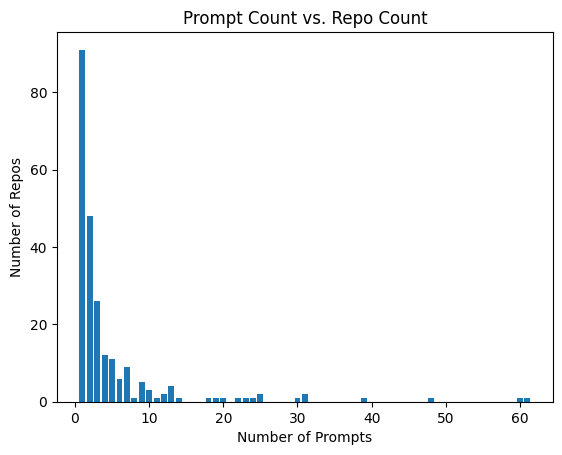

In [32]:
# Plot the distribution of prompt lengths
import matplotlib.pyplot as plt
import numpy as np

repo_to_promptCount = {}
for repo in repo_to_prompts:
    repo_to_promptCount[repo] = len(repo_to_prompts[repo])

# Prompt Count to Repo Count
promptCount_to_repoCount = {}
for repo in repo_to_promptCount:
    promptCount = repo_to_promptCount[repo]
    promptCount_to_repoCount[promptCount] = promptCount_to_repoCount.get(promptCount, 0) + 1

# Plot the distribution of prompt lengths
# plt.figure(figsize=(20,10))
plt.bar(promptCount_to_repoCount.keys(), promptCount_to_repoCount.values())
plt.xlabel("Number of Prompts")
plt.ylabel("Number of Repos")
plt.title("Prompt Count vs. Repo Count")
plt.show()


In [33]:
for repo in repo_to_promptCount:
    if repo_to_promptCount[repo] > 25:
        print(repo, repo_to_promptCount[repo])

melih-unsal~DemoGPT 60
DannyBoy5240~Langchain 30
aws-samples~amazon-kendra-langchain-extensions 31
836304831~langchain-anal 61
zapier~langchain-nla-util 31
langchain-ai~langchain 48
aws-solutions-library-samples~guidance-for-custom-search-of-an-enterprise-knowledge-base-on-aws 39
